In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Descomprimimos la base de datos**

In [9]:
from zipfile import ZipFile
file_name = '/content/drive/My Drive/Colab Notebooks/Ai Lab School/SESION 7/2._aclImdb.zip'
with ZipFile(file_name, 'r') as zip: 
    zip.extractall('') 

# **Construcción del conjunto de entrenamiento**

Organizamos las críticas en una lista (texts), donde cada crítica estará representada como un string.<br>
Asimismo, las etiquetas de estas críticas se almacenarán en un lista (labels).

In [10]:
import os

imdb_dir = '/content/aclImdb'   # Carpeta Riaz
train_dir = os.path.join(imdb_dir, 'train') #'/content/aclImdb/train' --> Carpeta de datos de entrenamiento

labels = []
texts = []

for label_type in ['neg', 'pos']:  # Iterar en las dos clases que se tienen
    dir_name = os.path.join(train_dir, label_type)  # Elegir carpeta de clases negativas
    for fname in os.listdir(dir_name):              # Entrar a las carpetas de la clase negativa
        if fname[-4:] == '.txt':                    # Se filtran los datos, para solo sacar los txt, que son los que nos interesan 
            f = open(os.path.join(dir_name, fname)) # Se accede al primer archivo
            texts.append(f.read())                  # Guardar la informacion en text
            f.close()                               # Cerramos el archivo
            if label_type == 'neg':                 # Condicion para colocar las etiquetas en cada texto
                labels.append(0)
            else:
                labels.append(1)

In [ ]:
texts

In [13]:
len(texts)

25000

In [ ]:
labels[12500]

1

# **Tokenización de las críticas**

Por tokenizar, nos referimos a descomponer cada una de las críticas en unidades básicas, en nuestro caso, vamos a descomponer las críticas en palabras, y a cada palabra se le asignará un índice, y de esta forma, podremos alimentar a la capa Embedding con palabras representadas como índices. <br>

Además, como los word embeddings pre-entrenados son útiles cuando nuestro conjunto de entrenamiento es pequeño, vamos a establecer la siguiente restricción: el conjunto de entrenamiento sólo recibirá las primeras 200 muestras. Entonces, nuestro modelo aprenderá a clasificar críticas de películas luego de procesar solamente 200 críticas.

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # Usaremos solamente las primeras 100 palabras de cada crítica
training_samples = 200  # El entrenamiento se realizará usando 200 muestras
validation_samples = 10000  # El conjunto de validación estará compuesto por 10,000 muestras
max_words = 10000  # Se usarán solamente las 10,000 palabras más populares de la base de datos

# Tokenizamos las críticas
tokenizer = Tokenizer(num_words=max_words)        # Tokenizer trabaja con las 10000 palabras mas populares
tokenizer.fit_on_texts(texts)                     # Se crea el diccionario
sequences = tokenizer.texts_to_sequences(texts)   # Convertimos cada critica en indices, text --> numeros 

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Aplicamos el recorte a cada crítica, y convertimos las listas de índices en tensores 2D de dimensiones (número de críticas, maxlen)
data = pad_sequences(sequences, maxlen=maxlen)   # Criticas con maximo 100 palabras

# Convertimos la lista de etiquetas en un arreglo
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Particionamos los datos en dos conjuntos: entrenamiento y validación.
# Pero antes, tenemos que organizar las muestras de forma aleatoria, ya que originalmente,
# primero se encuentran todas las críticas negativas y luego las positivas.

indices = np.arange(data.shape[0])   # Rango desde 0 hasta 25000
np.random.shuffle(indices)           # Orden aleatorio
data = data[indices]                 # Reordenamiento de criticas
labels = labels[indices]             # Reordenamiento de etiquetas

x_train = data[:training_samples]           # Las primeras 200 para entrenamiento
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]   
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [15]:
x_train[7]

array([ 198,    4,  921,  841,   60,  302,    4, 7894,  260,  290,  106,
          2,   24,  902,   23,   40,  340,   14,    3,   93,    5, 1275,
        927,    1,  724,  111,    1,  878,   13, 1153,    1,  412, 2753,
          5, 6800,    1,  299,    4,    1, 1903,   62,   48,   63,   90,
          1,   17,   30,   30,  219,   49,   13,   46, 1303,  113,   13,
        477,   14,    1, 3789, 1739,    2,    1, 9373,   68,   52,   49,
         14,   70,   79, 6600,  849,  624, 1605,   30,  219,   46,  110,
          5,    1,   19, 2753,    5,   94, 5000,  165,   30,  219, 2249,
         14,    3,  164,    7,    7, 1079,  454,  155,    7,    7,  297,
        238], dtype=int32)

In [16]:
len(sequences[30])

141

# **Descomprimimos la base de datos GloVe** | Transferencia de Aprendizaje

In [18]:
from zipfile import ZipFile
file_name = '/content/drive/My Drive/Colab Notebooks/Ai Lab School/SESION 7/2._ glove.6B.zip'
with ZipFile(file_name, 'r') as zip: 
    zip.extractall('') 

Construimos un diccionario que permita asociar cada palabra de la base de datos GloVe, con su representación de word embeddings.

In [21]:
import numpy as np
# Tomar los word embiding y tomar su etiqueta
embeddings_index = {}                   # Crear un diccionario para guardar los valores   
f = open('/content/glove.6B.100d.txt')  # Abrir archivo
for line in f:                          # Iterar en cada una de sus 400,000 lineas de texto
    values = line.split()               # Dividir cada elemento de la reseña (numeros) de la primera linea
    word = values[0]                    # Primer elemento de cada linea es la palabra (etiqueta)
    coefs = np.asarray(values[1:], dtype='float32')   # El resto de la linea son los pesos, se convierten a flotante
    embeddings_index[word] = coefs                    # Crear diccionario con la etiqueta y los valores
f.close()                                             # Cerrar el archivo

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Ahora, construyamos una matriz embedding que pueda ser cargada en la capa Embedding.  Esta matriz, debe ser de dimensiones (max_words, embedding_dim), donde cada entrada i contiene un vector de embedding_dim dimensiones, representando a la palabra de índice i de word_index, el cual se creó durante la tokenización. El índice 0 no tiene asignado ninguna palabra, ya que es un placeholder.

In [22]:
# Revisar
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

# **Definimos la arquitectura**

Esta arquitectura es exactamente igual que la anterior.

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


Cargamos la base de datos GloVe en el modelo

In [24]:
model.layers[0].set_weights([embedding_matrix])  # Definimos los pesos de inicio
model.layers[0].trainable = False                # La primera capa no se entrena, para no perder el aprendizaje

# **Entrenamiento y validación**

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/Ai Lab School/SESION 7/trained_glove_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    callbacks = [mc])

Epoch 1/10
7/7 [==============================] - 1s 135ms/step - loss: 0.8375 - acc: 0.8550 - val_loss: 1.1373 - val_acc: 0.5686

Epoch 00001: val_acc improved from -inf to 0.56860, saving model to /content/drive/My Drive/Colab Notebooks/Ai Lab School/SESION 7/trained_glove_model.h5
Epoch 2/10
7/7 [==============================] - 1s 113ms/step - loss: 3.8979e-04 - acc: 1.0000 - val_loss: 1.1356 - val_acc: 0.5686

Epoch 00002: val_acc did not improve from 0.56860
Epoch 3/10
7/7 [==============================] - 1s 114ms/step - loss: 3.4459e-04 - acc: 1.0000 - val_loss: 1.1508 - val_acc: 0.5692

Epoch 00003: val_acc improved from 0.56860 to 0.56920, saving model to /content/drive/My Drive/Colab Notebooks/Ai Lab School/SESION 7/trained_glove_model.h5
Epoch 4/10
7/7 [==============================] - 1s 220ms/step - loss: 3.2690e-04 - acc: 1.0000 - val_loss: 1.1313 - val_acc: 0.5701

Epoch 00004: val_acc improved from 0.56920 to 0.57010, saving model to /content/drive/My Drive/Colab No

Best accuracy epoch :  9, Value :  0.5727000237
Best loss epoch :  6, Value :  1.1256413460


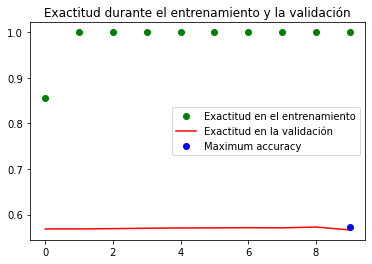

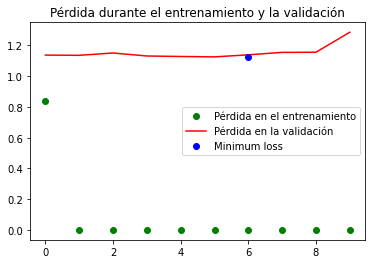

In [28]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
max_val_acc = max(val_acc)
max_val_acc_epoch= val_acc.index(max(val_acc)) + 1
loss = history.history['loss']
val_loss = history.history['val_loss']
min_val_loss = min(val_loss)
min_val_loss_epoch= val_loss.index(min(val_loss)) + 1

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Exactitud en el entrenamiento')
plt.plot(epochs, val_acc, 'r', label='Exactitud en la validación')
plt.plot(max_val_acc_epoch, max_val_acc, 'bo', label='Maximum accuracy')
plt.title('Exactitud durante el entrenamiento y la validación')
plt.legend()
print("Best accuracy epoch : % d, Value : % .10f" %(max_val_acc_epoch, max_val_acc)) 
plt.figure()

plt.plot(epochs, loss, 'go', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida en la validación')
plt.plot(min_val_loss_epoch, min_val_loss, 'bo', label='Minimum loss')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.legend()
print("Best loss epoch : % d, Value : % .10f" %(min_val_loss_epoch, min_val_loss))

plt.show()

# **Evaluación del modelo**

Primero es necesario tokenizar el conjunto de prueba

In [29]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

Cargamos el modelo y luego lo evaluamos

In [30]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/Colab Notebooks/Ai Lab School/SESION 7/trained_glove_model.h5', compile = True)
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 3ms/step - loss: 1.1256 - acc: 0.5708


[1.125615119934082, 0.5708400011062622]